# Need for Speed: Alternatives to our beloved Pandas

## 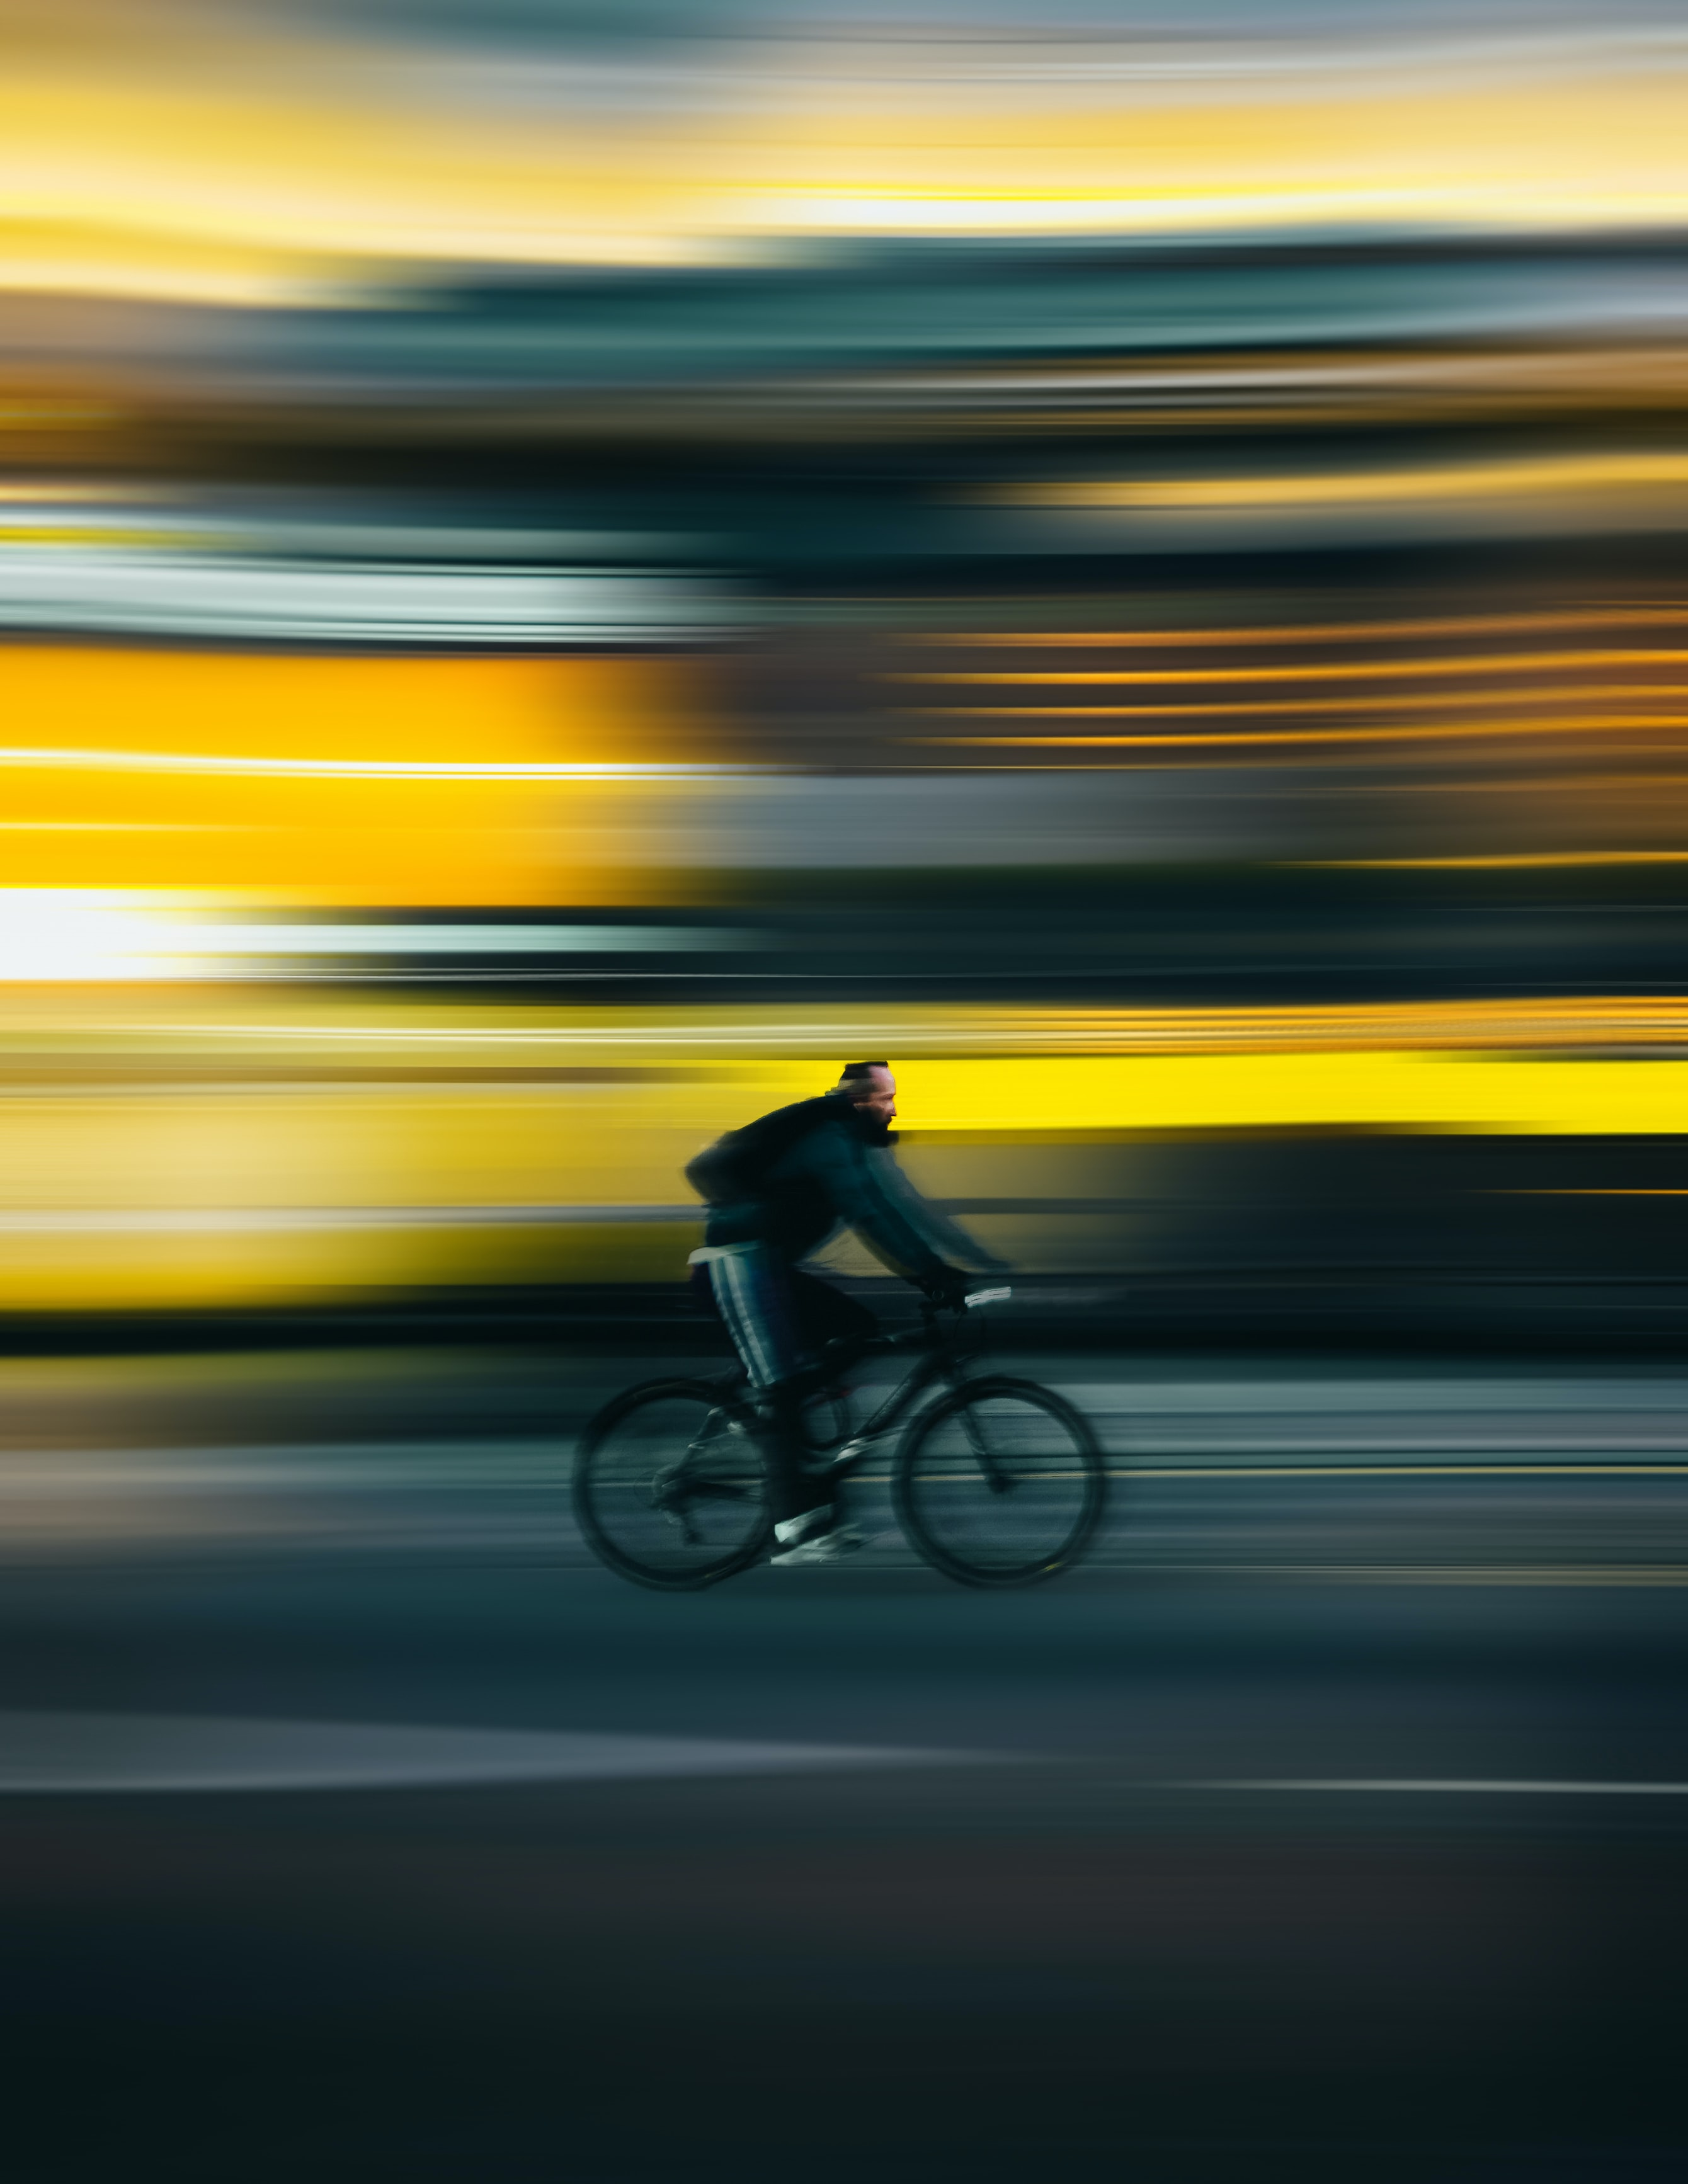

In the last article we studied that 
* Polars does provide a drammatic improvement in the time cosumed to conduct a task of reading the data into Polars dataframe. 
* Polars allows lazy operations hence the code is not executed until it is explicitly asked to be executed

In today's experiment we are going to quickly check the impact of polars objects in terms of memory consumed. At the end of the article we will conclude what method of Polars dataframes consume the least amount of memory and are still functionally better or equivalent to the defaults. 

So, Let's get stated ! 

***

Our setup remains same as before 

In [1]:
! python --version

Python 3.9.4


## Installing polars

In [2]:
! pip install polars

In [3]:
import polars as pl

## Getting the data

As always we start with reading the NY taxi data for Jan 2021 using Pandas. First we download data from amazon S3 link to a local storage. 

In [4]:
! wget "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2021-01.csv"
! wc -l yellow_tripdata_2021-01.csv

--2022-03-11 07:32:13--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2021-01.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.0.130
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.0.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125981363 (120M) [text/csv]
Saving to: ‘yellow_tripdata_2021-01.csv.3’

yellow_tripdata_202 100%[===================>] 120.14M  27.5MB/s    in 7.6s    

2022-03-11 07:32:21 (15.9 MB/s) - ‘yellow_tripdata_2021-01.csv.3’ saved [125981363/125981363]

 1369766 yellow_tripdata_2021-01.csv


## Lets do the things pandas way first and get the benchmark

In [5]:
import pandas as pd 
import datetime

In [6]:
%%time 
data = pd.read_csv("yellow_tripdata_2021-01.csv", low_memory=False)

CPU times: user 1.63 s, sys: 195 ms, total: 1.83 s
Wall time: 1.83 s


In [7]:
from sys import getsizeof

def whats_my_footprint(x):
    if 'x' in locals() or 'x' in globals():
        size = round(getsizeof(data) / 1024 / 1024,2)
        print(f'{size} MB in the memory')
    else:
        print('are you sure the object exists?')

whats_my_footprint(data)

428.64 MB in the memory


Pandas dataframe ended up taking almost 430MB of data in the memory. Lets take a look at the data types. 

In [8]:
display(data.dtypes)

VendorID                 float64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

We can see that the dates in the datta are not inferred as dates but as objects. Objects are the most memory ineffiient things in a dataframe. Objects are "anything" in this case a string. We need to encode them into the underlying numeric form to take less space and allow more efficient comutations in the future. 

In [9]:
%%time
# creating a date parser to reformat the dates in this data 
mydateparser = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv("yellow_tripdata_2021-01.csv", parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'],
date_parser=mydateparser, low_memory=False)
display(data.dtypes)

VendorID                        float64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                    float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

CPU times: user 15.7 s, sys: 287 ms, total: 16 s
Wall time: 16 s


In [10]:
whats_my_footprint(data)

250.99 MB in the memory


The number of rows in the inpute file is 1,369,766. The operation time from reading csv using defaults to reading the file and parsing dates shot 10x. The file size decreased from 430MB to 251MB. That is a 41% decrease in the memory footprint just by assigning the correct data types. 

***

We still have the store_and_fwd_flag as the object. We could fix it and optimize it further. Lets see what we can do.

In [11]:
%%time

display(data.store_and_fwd_flag.value_counts())
data.store_and_fwd_flag = data.store_and_fwd_flag.astype('category')
display(data.dtypes)
display(whats_my_footprint(data))

N    1252433
Y      18980
Name: store_and_fwd_flag, dtype: int64

VendorID                        float64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag             category
PULocationID                      int64
DOLocationID                      int64
payment_type                    float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

178.96 MB in the memory


None

CPU times: user 75.3 ms, sys: 3.92 ms, total: 79.3 ms
Wall time: 78.4 ms


So, we ended up taking another few seconds to convert an obviously categorical feature that Pandas failed to read correctly, converting it into the categorical form, and reducing footprint from 251 MB to 179 MB. Making our total reduction in footprint by 58.3% over the defaults ! That is a lot of wasted memory. 

***

Let's see how Polars does it 

## Reading the data using Polar

There are 2 main ways one can read the data into Polar. 
1. Polars.scan_<format>
2. Polars.read_<format>
    
Polars can handle csv, ipc, parquet, sql, json, and avro so we have 99% of our bases covered. So without further adue lets read in the csv file for NY taxi data for the month of Jan 2021.

In [28]:
df = pl.read_csv("yellow_tripdata_2021-01.csv")
display(df.head())

# selecting all columns 
data = df[[pl.col("*"),]]
display(type(data))
display(whats_my_footprint(data))


# selecting all columns and converting it to arrow format 
data = df[[pl.col("*"),]].to_arrow()
display(whats_my_footprint(data))
display(type(data))
display(data)


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
i64,str,str,i64,f64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""2021-01-01 00:30:10""","""2021-01-01 00:36:12""",1,2.1,1,"""N""",142,43,2,8.0,3.0,0.5,0.0,0.0,0.3,11.8,2.5
1,"""2021-01-01 00:51:20""","""2021-01-01 00:52:19""",1,0.2,1,"""N""",238,151,2,3.0,0.5,0.5,0.0,0.0,0.3,4.3,0.0
1,"""2021-01-01 00:43:30""","""2021-01-01 01:11:06""",1,14.7,1,"""N""",132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0
1,"""2021-01-01 00:15:48""","""2021-01-01 00:31:01""",0,10.6,1,"""N""",138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0
2,"""2021-01-01 00:31:49""","""2021-01-01 00:48:21""",1,4.94,1,"""N""",68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5


polars.internals.frame.DataFrame

0.0 MB in the memory


None

239.78 MB in the memory


None

pyarrow.lib.Table

pyarrow.Table
VendorID: int64
tpep_pickup_datetime: large_string
tpep_dropoff_datetime: large_string
passenger_count: int64
trip_distance: double
RatecodeID: int64
store_and_fwd_flag: large_string
PULocationID: int64
DOLocationID: int64
payment_type: int64
fare_amount: double
extra: double
mta_tax: double
tip_amount: double
tolls_amount: double
improvement_surcharge: double
total_amount: double
congestion_surcharge: double
----
VendorID: [[1,1,1,1,2,1,1,1,1,1,...,null,null,null,null,null,null,null,null,null,null]]
tpep_pickup_datetime: [["2021-01-01 00:30:10","2021-01-01 00:51:20","2021-01-01 00:43:30","2021-01-01 00:15:48","2021-01-01 00:31:49","2021-01-01 00:16:29","2021-01-01 00:00:28","2021-01-01 00:12:29","2021-01-01 00:39:16","2021-01-01 00:26:12",...,"2021-01-25 08:14:36","2021-01-25 08:25:06","2021-01-25 08:57:00","2021-01-25 08:55:00","2021-01-25 08:31:00","2021-01-25 08:32:04","2021-01-25 08:34:00","2021-01-25 08:37:00","2021-01-25 08:28:00","2021-01-25 08:38:00"]]
tpep_dropo

Important to note here is that Polars object dataframe did not have any memory footprint. It is just a map of the manipulations to be done over the original frame. Even using "read_csv" (as compared to "scan_csv" which produces a lazyframe); we ended up with a polars.internals.frame.DataFrame which had a 0 MB size. 

***

We still have the date columns and the sotLets use pyarrow.compute to convert the store_and_forward_flag columns in the large string format. Let's convert them into the date format and categorical formats 

In [29]:
from pyarrow import compute as pc
from pyarrow import Table as pt  


def fix_datetime(x, column_name):
    replacement = pc.strptime(x.column(column_name), format='%Y-%m-%d %H:%M:%S', unit='s')
    position = x.column_names.index(column_name)
    x = x.set_column(position, column_name, replacement)
    return x 
     
def fix_categories(x, column_name):
    replacement = x.column(column_name).dictionary_encode()
    position = x.column_names.index(column_name)
    x = x.set_column(position, column_name, replacement)
    return x 

data = fix_datetime(data, 'tpep_pickup_datetime')  
data = fix_datetime(data, 'tpep_dropoff_datetime')  
data = fix_categories(data, 'store_and_fwd_flag')  

data.schema

VendorID: int64
tpep_pickup_datetime: timestamp[s]
tpep_dropoff_datetime: timestamp[s]
passenger_count: int64
trip_distance: double
RatecodeID: int64
store_and_fwd_flag: dictionary<values=large_string, indices=int32, ordered=0>
PULocationID: int64
DOLocationID: int64
payment_type: int64
fare_amount: double
extra: double
mta_tax: double
tip_amount: double
tolls_amount: double
improvement_surcharge: double
total_amount: double
congestion_surcharge: double

In [30]:
whats_my_footprint(data)

184.03 MB in the memory


## Polars with explicit specifications of dtypes

Another approach could be to as Polars to do as much of a job as it can do to infer the data types and confirm the rest of the datatypes explicitly.

In [35]:
%%time
df = pl.scan_csv("yellow_tripdata_2021-01.csv")
df = df.with_columns(
    [
        pl.col("tpep_pickup_datetime").str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S'),
        pl.col("tpep_dropoff_datetime").str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S')
    ]
).collect()
display(df.schema)

{'VendorID': polars.datatypes.Int64,
 'tpep_pickup_datetime': polars.datatypes.Datetime,
 'tpep_dropoff_datetime': polars.datatypes.Datetime,
 'passenger_count': polars.datatypes.Int64,
 'trip_distance': polars.datatypes.Float64,
 'RatecodeID': polars.datatypes.Int64,
 'store_and_fwd_flag': polars.datatypes.Utf8,
 'PULocationID': polars.datatypes.Int64,
 'DOLocationID': polars.datatypes.Int64,
 'payment_type': polars.datatypes.Int64,
 'fare_amount': polars.datatypes.Float64,
 'extra': polars.datatypes.Float64,
 'mta_tax': polars.datatypes.Float64,
 'tip_amount': polars.datatypes.Float64,
 'tolls_amount': polars.datatypes.Float64,
 'improvement_surcharge': polars.datatypes.Float64,
 'total_amount': polars.datatypes.Float64,
 'congestion_surcharge': polars.datatypes.Float64}

CPU times: user 1.01 s, sys: 262 ms, total: 1.27 s
Wall time: 536 ms


In [36]:
whats_my_footprint(df)

184.03 MB in the memory


By now you must have noticed that Polaris objects dont take any space. However, once converted to pandas or arrow or any other realized format, they take the same expected space as any other tool would. The main gain is the speed and flexibility. 

## Conclusion 

Polars is a mere orchestration layer that does many smart things. The Polars objects are like maps for the actual execution. Unless its necessary it will not create a redundant object in the memory which should ultimately save one a ton of time. 

At heart Polars is an Apache arrow based columnar frame. It executes functions smartly to save time and memory. Ultimately, you will need to convert the Polars.dataframe into Pandas.Dataframe or whatever object that you want to save your data into and "realize" the changes that have been smartly sequenced and orchestrated by Polars.

A quick note: to_pandas() broken (fix)
Polars installation does not install pyarrow as a dependency. I would highly recommend installing pyarrow as a separate installation using pip install pyarrow. You will need to reinstall/upgrade polars after pyarrow. This way it will identify pre-existing pyarrow installation and allow you to do many things like call function _pl.dataframe.to_pandas()_. This difference is because internally polars uses pyarrow batching of the task (a reason for the performance). 

Next time we will take a deeper look into how efficient Polars is vs Pandas in doing some tasks that we generally end up doing. We will time it and check footprint (in memory during processing) at each step to give complete picture. 

Until then, keep coding ! 